In [6]:
!pip install \
'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q roboflow supervision
!wget -q \
'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/_7/zhxrcnb92sd44n2lh08mdcn00000gn/T/pip-req-build-idwv4x4w
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/_7/zhxrcnb92sd44n2lh08mdcn00000gn/T/pip-req-build-idwv4x4w
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch
from segment_anything import sam_model_registry, SamPredictor

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to(device=DEVICE)

ModuleNotFoundError: No module named 'segment_anything'

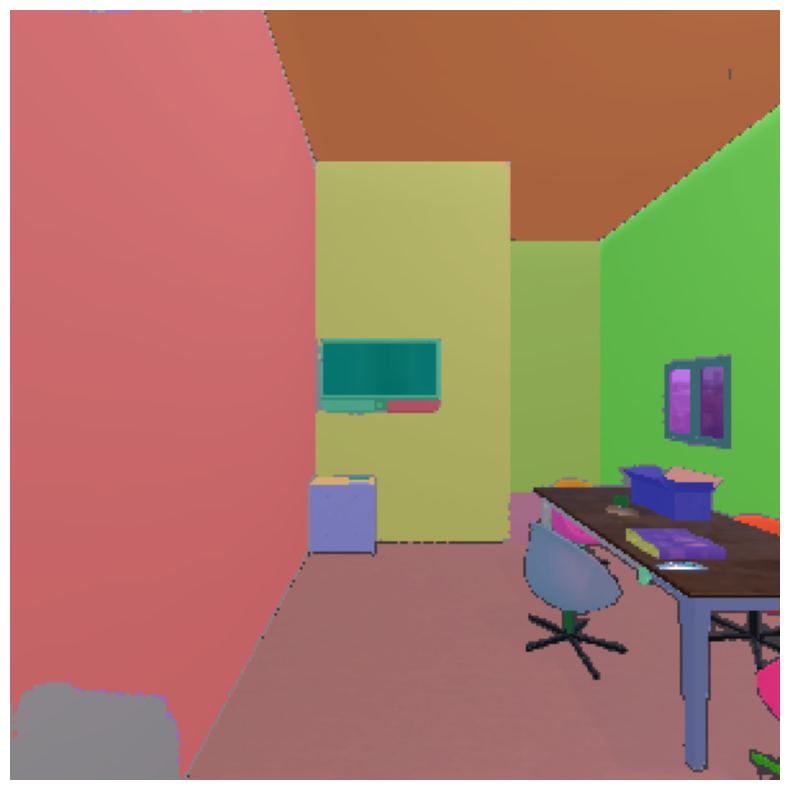

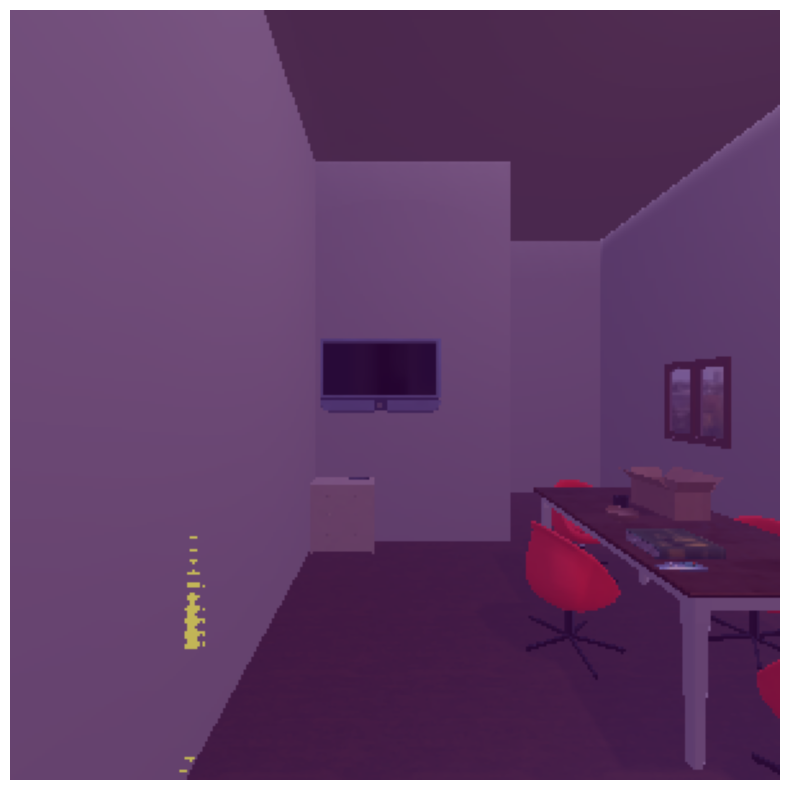

In [9]:

import numpy as np
import supervision as sv
import matplotlib.pyplot as plt
import cv2

from segment_anything import SamPredictor,SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(sam)
# Load image
image_bgr = cv2.imread('/Users/darpalpatel/Projects/NavAssistant/Exploration/data/images/frame_0.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# --- Automatic masks ---
mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image_rgb)

result = mask_generator.generate(image_rgb)
detections = sv.Detections.from_sam(result)

# Assign class IDs
detections.class_id = np.arange(len(detections))

# Annotate masks
mask_annotator = sv.MaskAnnotator()
annotated_image = mask_annotator.annotate(image_bgr, detections)

plt.figure(figsize=(10,10))
plt.imshow(annotated_image[..., ::-1])
plt.axis('off')
plt.show()

# --- Box-based prediction ---
mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image_rgb)

box = np.array([70, 247, 626, 926])
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

best_mask = masks[np.argmax(scores)]

plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
plt.imshow(best_mask, alpha=0.5)
plt.axis('off')
plt.show()


In [10]:
boxes = []
for mask in result:  # result from mask_generator.generate()
    ys, xs = np.where(mask['segmentation'] > 0)  # get coordinates of mask pixels
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    boxes.append([x_min, y_min, x_max, y_max])

32


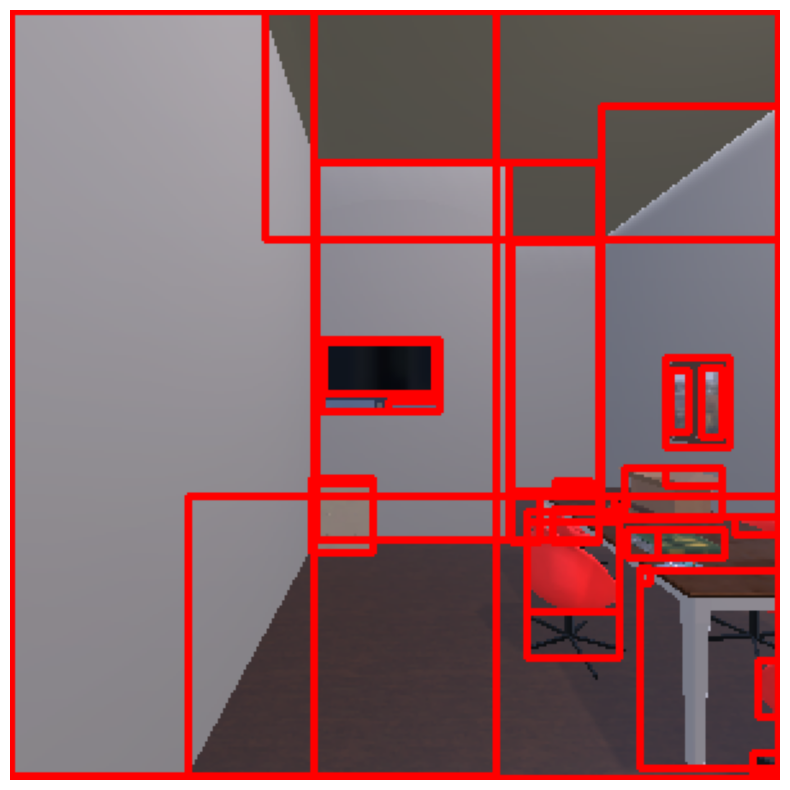

In [11]:
import cv2

image_copy = image_rgb.copy()
print(len(boxes))
for box in boxes:
    x_min, y_min, x_max, y_max = box
    cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), color=(255,0,0), thickness=2)

plt.figure(figsize=(10,10))
plt.imshow(image_copy)
plt.axis('off')
plt.show()

In [12]:
from PIL import Image

def crop_mask(image, mask):
    """
    image: HxWxC numpy array (RGB)
    mask: HxW binary mask (bool or 0/1)
    returns PIL Image cropped to the mask bounding box
    """
    ys, xs = mask.nonzero()
    if len(ys) == 0 or len(xs) == 0:
        return None
    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()
    cropped = image[y1:y2+1, x1:x2+1]
    return Image.fromarray(cropped)

In [13]:
import transformers
print(transformers.__version__)
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from PIL import Image

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

image = Image.open("/Users/darpalpatel/Projects/NavAssistant/Exploration/data/images/frame_0.png")
inputs = processor(images=image, return_tensors="pt")


5.0.0.dev0


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading weights: 100%|██████████| 473/473 [00:00<00:00, 1445.98it/s, Materializing param=text_decoder.bert.embeddings.LayerNorm.bias]                              
BlipForConditionalGeneration LOAD REPORT from: Salesforce/blip-image-captioning-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [14]:
outputs = model.generate(**inputs)
caption = processor.decode(outputs[0], skip_special_tokens=True)
print("Generated Caption:", caption)

Generated Caption: a room with a desk, chair, and television
